## Polytope On-Demand DT Trajectory example notebook

This notebook shows two ways on how to use earthkit-data and earthkit-plots to pull destination-earth data from LUMI and plot data along a trajectory using earthkit-plots. The first example uses the polytope feature extraction and the second does a interpolation with earthkit.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [ ]:
%%capture cap
%run ../desp-authentication.py

This will generate a token that can then be used by earthkit and polytope.

In [ ]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install earthkit-plots
* pip install earthkit-geo
* pip install earthkit-regrid  (Optional for spectral variables)
* pip install cf-units         (Optional for unit conversion in maps)

If you do not have eccodes installed please install eccodes using conda as it is a dependency of earthkit, or install earthkit via conda

* conda install eccodes -c conda-forge
* conda install earthkit-data -c conda-forge

In [1]:
import earthkit.data
import earthkit.plots
from earthkit.geo import nearest_point_kdtree


In [2]:
train_route = []

# Inverness
train_route.append([57.479, 360-4.223])

# Perth
train_route.append([56.395, 360-3.435])

# Edinburg Waverley
train_route.append([55.952, 360-3.189])

# Carlisle
train_route.append([54.892, 360-2.933])

# Lancaster
train_route.append([54.047, 360-2.808])

# Preston
train_route.append([53.757, 360-2.703])

# Crewe
train_route.append([53.089, 360-2.435])

# Birmingham New Street
train_route.append([52.478, 360-1.899])



In [3]:
request_feature = {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "stream": "oper",
    "type": "fc",
    "date": "20250926",
    "time": "0000",
    "levtype": "sfc",
    "expver": "0099",
    "param": "167",
    "georef": "gcgkrb",
    "step": "1",
    "feature" :{ 
        "type" : "trajectory", 
        "points" : train_route, 
        "inflation" : 0.01, 
        "inflate" : "round",
        "axes" :["latitude", "longitude"], 
    },
}

In [ ]:
data_feature = earthkit.data.from_source("polytope", "destination-earth", request_feature,
                               stream=False,
                               address="polytope.lumi.apps.dte.destination-earth.eu",
                               )

In [5]:
ds = data_feature.to_xarray()
ds

<xarray.Dataset> Size: 157kB
Dimensions:    (datetimes: 1, number: 1, steps: 1, points: 3276)
Coordinates:
  * datetimes  (datetimes) <U20 80B '2025-09-26T00:00:00Z'
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 1
  * points     (points) int64 26kB 0 1 2 3 4 5 ... 3270 3271 3272 3273 3274 3275
    latitude   (points) float64 26kB 52.47 52.47 52.47 ... 57.48 57.48 57.49
    longitude  (points) float64 26kB 358.1 358.1 358.1 ... 355.8 355.8 355.8
    levelist   (points) float64 26kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time       (points) int64 26kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Data variables:
    2t         (datetimes, number, steps, points) float64 26kB 281.9 ... 282.7
Attributes:
    class:          d1
    dataset:        on-demand-extremes-dt
    stream:         oper
    expver:         0099
    type:           fc
    Forecast date:  2025-09-26T00:00:00Z
    levtype:        sfc
    georef:         gcgkrb
    step:           1
    number:         0

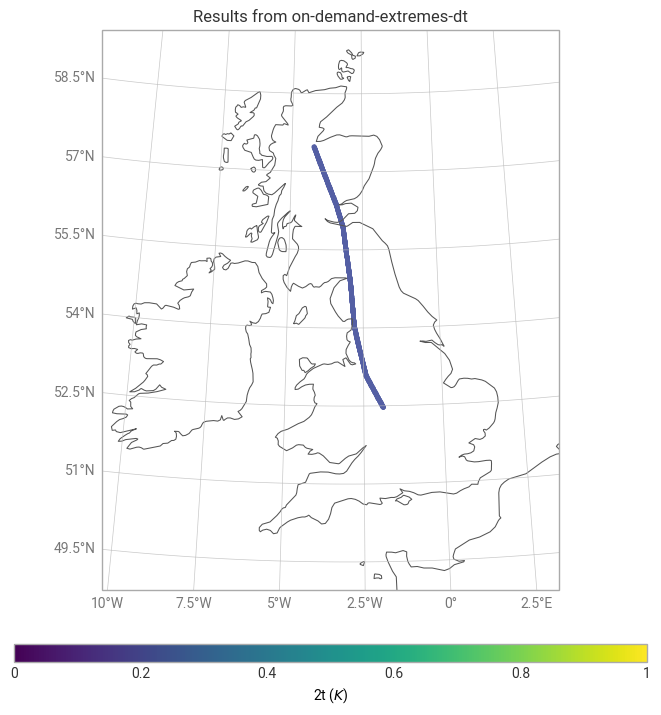

In [6]:
import earthkit.plots
chart = earthkit.plots.Map(domain=["Ireland", "United Kingdom"])
chart.point_cloud(
    ds['2t'],
    x="longitude",
    y="latitude",
)
chart.title(f"Results from on-demand-extremes-dt")
chart.coastlines()
chart.gridlines()
chart.legend()
chart.show()

## Example without feature extraction
As an alternative to the feature extraction we can do the intepolation to the requested point locally instead. Let's request the data again

In [7]:
request = {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "stream": "oper",
    "type": "fc",
    "date": "20250926",
    "time": "0000",
    "levtype": "sfc",
    "expver": "0099",
    "param": "167",
    "georef": "gcgkrb",
    "step": "1",
}

In [ ]:
data = earthkit.data.from_source("polytope", "destination-earth", request,
                               stream=False,
                               address="polytope.lumi.apps.dte.destination-earth.eu",
                               )

In [9]:
# Gather the train points in two lists
lats = []
lons = []
for lat, lon in train_route:
    lats.append(lat)
    lons.append(lon)

In [10]:
# Find nearest gridpoints using kdtree

from earthkit.geo import nearest_point_kdtree

latlon = data.to_latlon()
lat = latlon["lat"]
lon = latlon["lon"]
idx, distance = nearest_point_kdtree([lats,lons], (lat, lon))

In [11]:
data[0].values[idx]

array([282.62420654, 281.73406982, 282.99456787, 281.08172607,
       281.42108154, 282.78729248, 282.44793701, 282.5536499 ])

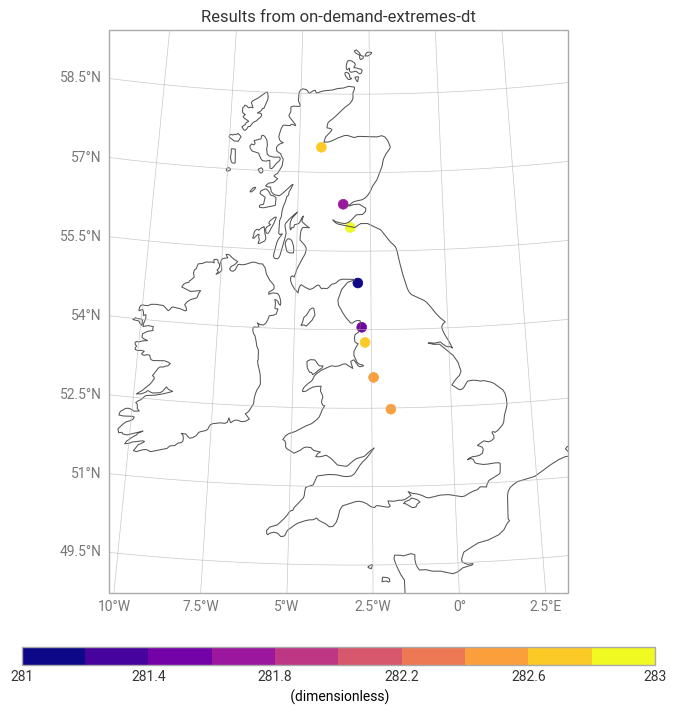

In [12]:
# Plot the interapolated data, note that this 
# trajectory will only show the points we extracted

chart = earthkit.plots.Map(domain=["Ireland", "United Kingdom"])
chart.point_cloud(
    data[0].values[idx],
    x=lons,
    y=lats,
    s=50,
)
chart.title(f"Results from on-demand-extremes-dt")
chart.coastlines()
chart.gridlines()
chart.legend()
chart.show()